# Can the vaccine against COVID-19 avoid further lockdowns?

Dated: 21.11.2020

In this notebook we present a simplified model to estimate the number of lockdowns needed to control the pandemic in Germany. The model assumes that a vaccine against COVID-19 will be available soon. 

These are the most important assumptions of the model: 

* The SIR-model is used and adapted as follows: We estimate also the number of deaths (D) and successfully vaccinated susceptibles (S) are moved to the recovered people (R).  
* We assume that recovered people (either infected or vaccinated previously) will remain immune. 
* The vaccine shows effects 28 days after the first vaccination has been given.
* The vaccine can avoid 90% of infections. 
* If a person got vaccinated, it cannnot infect other people. 
* 70% of the German population is willing to get vaccinated. 
* The high risk group will receive the vaccination before everyone else.
* Whenever the incidence for the high risk group becomes too large there will be a lockdown to lower the daily incidence. 
* Once the daily incidence has dropped below 1000 new infections per day the lockdown terminates. 
* We assume that the lockdows are efficient enough to have an effective reproduction number $\mathcal{R}=0.7$.
* Outside the lockdown the effective reproduction number $\mathcal{R}$ will be a parameter of the model to be chosen. 
* The transition between $\mathcal{R}$ during lockdown and outside of lockdown is not continuous. Hence, we assume instantaneous adaption.
* The infection fatality rate is assumed to be 2% for the high risk group and 0,5% for the whole population. 

Notice: Seasonal effects are not included in the model. Instead we assume that a lockdown in fall or winter must be more restrictive than in summer. This assumption is expected to compensate the current inadequacy of the model.

### Implementation of the model

In [1]:
from matplotlib import pyplot as plt

def lockdown_model(basis_reproduction_number, visibility, total_population, incidence, infectious, recovered, deaths, vaccination_rate, high_risk_group, availability, start, end, flag):
   
 # setting initial conditions
        
    # notation
    N = total_population
    I= infectious/visibility
    R = recovered/visibility
    D = deaths
    t = start # starting point
    T = end # end day of computation 

    # implications
    S = N - I - R
    duration = T - t # number of days to simulate
    
# Fixed valued parameters of the model 
    
    # virus
    recovery = 10 # in days, actual recovery or death
    gamma = 1/recovery # recovery rate
    lethality_rate = 0.005 # probability of dying due to covid 19; the apparent lethality rate worldwide seems to be 3% based o repored figures
    critical = 20000
    subcritical = 1000
    
    # vaccination
    vacc = vaccination_rate/2 # per day; divided by 2 because we need two injections
    V = 0 # initially
    #availability = availability # days from now
    delay = 28 # delay until protection begins
    vaccination_success = 0.9
    vaccination_acceptance = 0.7
    stock = 56e6 # how many people can be vaccinated?
    V_max = min(S*vaccination_acceptance, stock)
    
    # high risk group 
    ratio_hr = high_risk_group # proportion of high risk group
    critical_eff = critical*ratio_hr # acceptable incidence of high risk people
    lethality_rate_hr = 0.02 # lethality rate for high risk group
    lethality_rate_rest = max((lethality_rate-ratio_hr*lethality_rate_hr)/(1-ratio_hr),0)
    S_hr_fail = S*ratio_hr*((1-vaccination_acceptance) + vaccination_acceptance*(1-vaccination_success))
    
# definition of lists for the purpose of plotting
    
    V_list = [V]
    S_list = [S]
    I_list = [I]
    R_list = [R]
    New_list = [incidence/visibility]
    D_list = [D]
    time = [t]
    
# solving the SIR model numerically
  
    mode = flag # flag for lockdown vs. normal
    count_lockdowns = 0
    count_days_in_lockdown = 0
    list_lockdowns = []
    days_in_lockdown = []
    
    for i in range (1, duration):
        
        if mode == 'lockdown':
            R0 = 0.7 # effective reproduction number during lockdown
            if count_lockdowns == 0:
                count_lockdowns = 1 
        else:
            R0 = basis_reproduction_number # (initial) basis reproduction number
        
        New = gamma*R0*S*I/N # new cases
        New_hr = New*ratio_hr # new cases in the high risk group
        
        # criterion for lockdown
        if (New_hr > critical_eff) and (mode != 'lockdown'):
            mode = 'lockdown'
            count_lockdowns += 1
        
        # counting the total days of lockdown
        if mode == 'lockdown':
            count_days_in_lockdown += 1 
        
        # criterion for switching from lockdown to normal mode
        if (New < subcritical) and (mode == 'lockdown'):
            R0 = basis_reproduction_number
            mode = 'normal'
            list_lockdowns.append(count_days_in_lockdown)
        
        # counting number of people receiving vaccination for each day 
        # the criterions accounts for temporal delay in the protection
        if (V < V_max) and (i > delay + availability): 
            dV = min(vacc,S)
        else:
            dV = 0
        
        dS = - gamma*R0*I*S/N - vaccination_success*dV # change in the susceptibles
        dI = gamma*(R0*S/N-1)*I # change in the number of infectious people 
        dR = gamma*I # change in the number of recovered people accounting for deaths
        dD = gamma*I*(lethality_rate_rest*(1-ratio_hr)+lethality_rate_hr*ratio_hr)  # change in the number of deaths
        # updating those variables
        V = V + dV
        S = max(S + dS, 0)
        I = max(I + dI, 0)
        R = max(R + dR, 0)
        D = max(D + dD, 0)
        # inserting the variables to the corresponding lists
        V_list.append(V)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
        D_list.append(D)
        New_list.append(New)
        time.append(i)
                
        S_hr = ratio_hr*S # calculating the size of susceptible population among high risk group at the beginning of day i
        S_hr = S_hr - dI*ratio_hr # subtracting hr people who got infected before vaccination

        # this criterion ensures that the high risk group gets vaccination first
        if S_hr > S_hr_fail:
            S_hr = S_hr - dV # size of the susceptible high risk group at the end of day i
        
        ratio_hr = max(S_hr,0)/S # updating the proportion of the high risk group
         
    # counting the days for each lockdown
    for i in range(len(list_lockdowns)):
        if i == 0:
            days_in_lockdown.append(list_lockdowns[0])
        else:
            days_in_lockdown.append(list_lockdowns[i]-list_lockdowns[i-1])
        
    return time, S_list, New_list, I_list, R_list, D_list, V_list, days_in_lockdown

The function lockdown_model has the following input parameters: 
* (Effective) Reproduction number outside the lockdown. 
* Estimated fraction of unknown cases (in the following we ignore this factor as we are interested in the general dynamics)
* Total population 
* Incidence (per day)
* Number of currently actively infected people 
* Recovered people 
* Deaths 
* Vaccination rate (number of people per day) 
* Proportion of high risk group 
* Availability of the vaccine (in days from now) 
* Starting point of the computation (we will choose t=0)
* End of the computation (we will choose t=730 i.e. 2 years)
* A flag for setting whether we are currently in lockdown i.e. flag = 'lockdown' or else flag='normal'

The output of the function is: 
* A list of time stamps 
* A list of the number of susceptibles at every day
* A list of the number of incidences per day
* A list of the number of actively infected at every day
* A list of the number of recovered people (cumulated) at every day
* A list of the number of deaths (cumulated) at every day
* A list of the number of vaccinated people (cumulated) at every day
* A list with the durations (in days) of every lockdown

### The computation

We state some further assumptions: 
* We use the input data from Saturday, 21.11.2020
* The incidence is approximated by the 7-day average of the daily incidence. 
* In particular we choose the flag='lockdown' even though we have not yet reached $\mathcal{R}=0.7$ as assumed in the implementation. 
* We assume that $\mathcal{R}=1.5$ if there is no lockdown. Hence, we implicitly assume that: 
    * Without lockdows we accept some exponential growth. 
    * Since many research papers suggest $\mathcal{R}_0 \simeq 3 \pm 1$ our assumption of $\mathcal{R}=1.5$ means that even without lockdowns the population is cautions, keeps wearing masks, accepts physical distancing etc.  
* We assume that the high risk group is between 20-40% of the whole population. 
* We assume that the earliest starting point of the vaccination is January and the latest is April. 
* We assume that the number of vaccinations per day is between 60.000 and 180.000. (Note that [this paper](http://www.matthias.schrappe.com/einzel/thesenpapier_corona2.pdf) assumes 60.000 vaccinations per day at most.) 

In [2]:
A = lockdown_model(1.5, 1, 80e6, 18000, 310932, 607339, 14239, 180000, 0.2, 41, 0, 365*2, 'lockdown') # more optimistic
B = lockdown_model(1.5, 1, 80e6, 18000, 310932, 607339, 14239, 120000, 0.3, 86, 0, 365*2, 'lockdown') # moderate
C = lockdown_model(1.5, 1, 80e6, 18000, 310932, 607339, 14239, 60000, 0.4, 131, 0, 365*2, 'lockdown') # more pessimistic

#### Incidence curves 

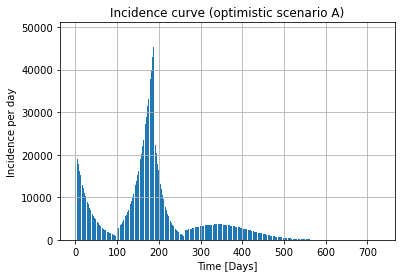

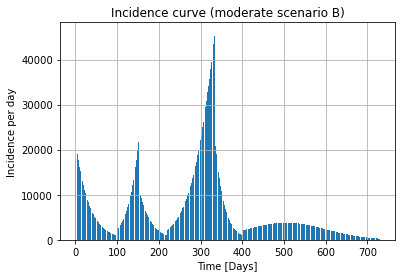

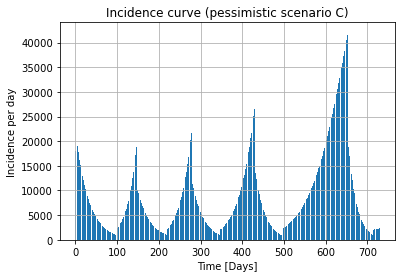

In [3]:
plt.grid(True)
plt.title('Incidence curve (optimistic scenario A)')
plt.xlabel('Time [Days]')
plt.ylabel('Incidence per day')
plt.bar(A[0], A[2])
plt.show()

plt.grid(True)
plt.title('Incidence curve (moderate scenario B)')
plt.xlabel('Time [Days]')
plt.ylabel('Incidence per day')
plt.bar(B[0], B[2])
plt.show()

plt.grid(True)
plt.title('Incidence curve (pessimistic scenario C)')
plt.xlabel('Time [Days]')
plt.ylabel('Incidence per day')
plt.bar(C[0], C[2])
plt.show()

#### Expected days in lockdown

In [4]:
print('Scenario A')
print('Number of lockdowns in scenario A:', len(A[7]))
print('Total number of days in lockdown in scenario A:', sum(A[7]))
print('Number of days in lockdown in scenario A:', A[7])
print('--------------------------------------------------------')
print('Scenario B')
print('Number of lockdowns in scenario B:', len(B[7]))
print('Total number of days in lockdown in scenario B:', sum(B[7]))
print('Number of days in lockdown in scenario B:', B[7])
print('--------------------------------------------------------')
print('Scenario C')
print('Number of lockdowns in scenario C:', len(C[7]))
print('Total number of days in lockdown in scenario C:', sum(C[7]))
print('Number of days in lockdown in scenario C:', C[7])

Scenario A
Number of lockdowns in scenario A: 2
Total number of days in lockdown in scenario A: 166
Number of days in lockdown in scenario A: [96, 70]
--------------------------------------------------------
Scenario B
Number of lockdowns in scenario B: 3
Total number of days in lockdown in scenario B: 233
Number of days in lockdown in scenario B: [98, 68, 67]
--------------------------------------------------------
Scenario C
Number of lockdowns in scenario C: 5
Total number of days in lockdown in scenario C: 364
Number of days in lockdown in scenario C: [98, 72, 68, 64, 62]


#### Death curves

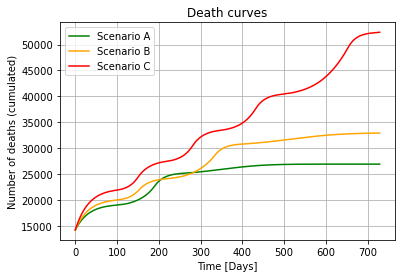

In [5]:
plt.grid(True)
plt.title('Death curves')
plt.xlabel('Time [Days]')
plt.ylabel('Number of deaths (cumulated)')
plt.plot(A[0], A[5], 'green', label='Scenario A')
plt.plot(B[0], B[5], 'orange', label='Scenario B')
plt.plot(C[0], C[5], 'red', label='Scenario C')
plt.legend()
plt.show()

### Conclusion

As of 21.11.2020 we should expect at least one further lockdown. This model is not precise enough to make precise predictions, but the scenarios suggest another lockdown around April 2021. Everything beyond will highly depend on policies but also on how many people can be vaccinated per day. If this number is as large as 60.000 vaccinations per day then the effect of the vaccine on the dynamics of the pandemic will occur only beyond the year 2021. It is therefore extremely important to maximise the number as much as possible. 

Furthermore, the results also suggest that a typical lockdown requires a lenght of at least 2 months. Since the current number of actively infected people in Germany is very large, the current (partial-)lockdown should even take rather 3 months (from now!). 

Regarding the death rate one should expect between 25.000-35.000 deaths due to COVID-19 in Germany by end of 2021, assuming that the 'lockdown-hopping' policy will remain and that the vaccine will be available between January and April 2021. Without lockdowns the number of deaths would range between 60.000 (Scenario A), 140.000 (Scenario B) and 300.000 (Scenario C) by end of 2021. 